In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2

In [3]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet50(pretrained=True)
        self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
        self.encoded_channels=1024
    
    def forward(self, image):
        a = self.extractor(image)
        return {
            'early': a['layer3_conv3'],
            'middle': a['layer3_conv3'],
            'deep': a['layer3_conv3'],
        }

torch.Size([2, 1, 36, 64])
torch.Size([565])
(36, 64)
(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19,
       19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21,
       21, 22, 22, 22, 22, 22, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29,
       29, 29, 29, 29, 29, 30, 30, 30, 30, 30

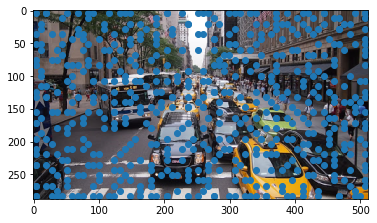

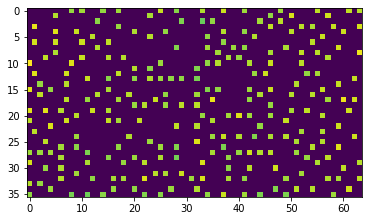

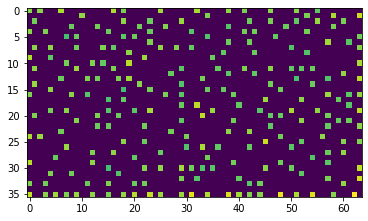

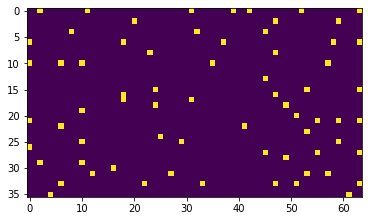

In [95]:
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3)
image = Image.open('/home/mark/Downloads/test.jpg')
image_np = np.array(image)
image = utils.preprocess_image(image_np)
image = torch.as_tensor(image)
image = torch.unsqueeze(image, 0)

keypoints, descriptors, scores, detections = extraction_model(image)

print(scores.size())
print(detections[0].shape)
print(np.nonzero(detections[0]))

plt.imshow(image_np)
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.show()
plt.imshow(detections[0])
plt.show()
plt.imshow(detections[1])
plt.show()
plt.imshow(detections[2])

In [83]:
pair_idx = 1
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

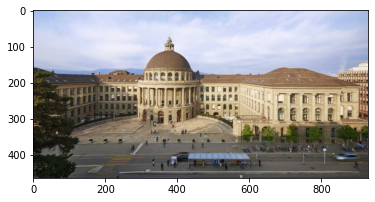

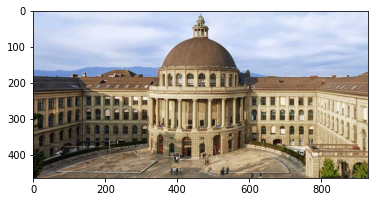

In [84]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [85]:
# encoder = DummyEncoder().eval()
# attention = attention_model.MultiAttentionLayer(encoder).eval()

# extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.0)
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3, thresh=0.2)

In [86]:
kp1, descr1, scores1, det1 = extraction_model(image1)
kp2, descr2, scores2, det2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]

print(scores1)
print(scores2)

torch.Size([2, 16, 58, 116])
torch.Size([2, 16, 58, 116])
75 --> 75
60 --> 60
tensor([0.2508, 0.2450, 0.2434, 0.2425, 0.2392, 0.2368, 0.2324, 0.2317, 0.2297,
        0.2243, 0.2210, 0.2192, 0.2190, 0.2178, 0.2163, 0.2155, 0.2155, 0.2133,
        0.2117, 0.2108, 0.2094, 0.2083, 0.2078, 0.2076, 0.2071, 0.2071, 0.2071,
        0.2067, 0.2067, 0.2065, 0.2064, 0.2059, 0.2058, 0.2057, 0.2056, 0.2053,
        0.2047, 0.2046, 0.2043, 0.2041, 0.2039, 0.2038, 0.2037, 0.2036, 0.2036,
        0.2035, 0.2034, 0.2033, 0.2031, 0.2030, 0.2029, 0.2028, 0.2027, 0.2026,
        0.2024, 0.2024, 0.2020, 0.2018, 0.2018, 0.2018, 0.2018, 0.2017, 0.2016,
        0.2016, 0.2015, 0.2014, 0.2013, 0.2012, 0.2012, 0.2011, 0.2006, 0.2004,
        0.2003, 0.2002, 0.2001])
tensor([0.2452, 0.2424, 0.2372, 0.2367, 0.2343, 0.2323, 0.2311, 0.2173, 0.2170,
        0.2144, 0.2136, 0.2129, 0.2110, 0.2109, 0.2105, 0.2100, 0.2096, 0.2094,
        0.2091, 0.2091, 0.2088, 0.2087, 0.2083, 0.2078, 0.2077, 0.2074, 0.2071,
        0

In [87]:
matches = match_descriptors(descr1, descr2, cross_check=True)
n_matches = len(matches)
print(len(matches))

24


In [88]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
print(keypoints_left)
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

[[ 28.902428    7.1076446]
 [311.17575     5.942934 ]
 [430.38477     6.432761 ]
 [151.84137     6.2870617]
 [669.7474      5.272396 ]
 [742.28986     5.176449 ]
 [ 48.003426  198.9538   ]
 [301.33167   340.32333  ]
 [434.35733   445.40347  ]
 [718.75256   413.47437  ]
 [624.80884    96.15277  ]
 [534.97424   342.88785  ]
 [515.5083    186.04904  ]
 [810.69727    36.073082 ]
 [480.86835   348.45383  ]
 [202.07701   352.82147  ]
 [680.134     128.59528  ]
 [404.08453   354.15295  ]
 [267.9992    276.40317  ]
 [330.61945    98.15124  ]
 [896.7627    437.67307  ]
 [853.69147   267.47736  ]
 [737.37      228.87386  ]
 [411.88486   321.10303  ]]
Number of inliers: 5.


[[ 28.902428    7.1076446]
 [311.17575     5.942934 ]
 [669.7474      5.272396 ]
 [301.33167   340.32333  ]
 [737.37      228.87386  ]]
[[336.85468     6.5786247]
 [397.0488      6.4219074]
 [636.1067      6.482559 ]
 [332.10144   145.45486  ]
 [552.1664    223.00655  ]]


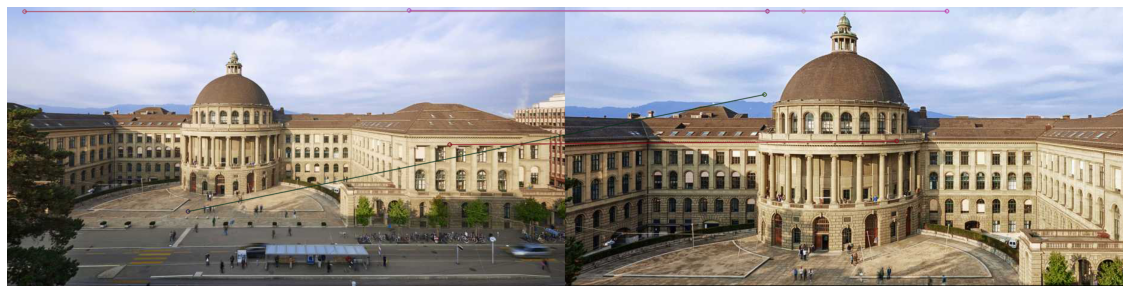

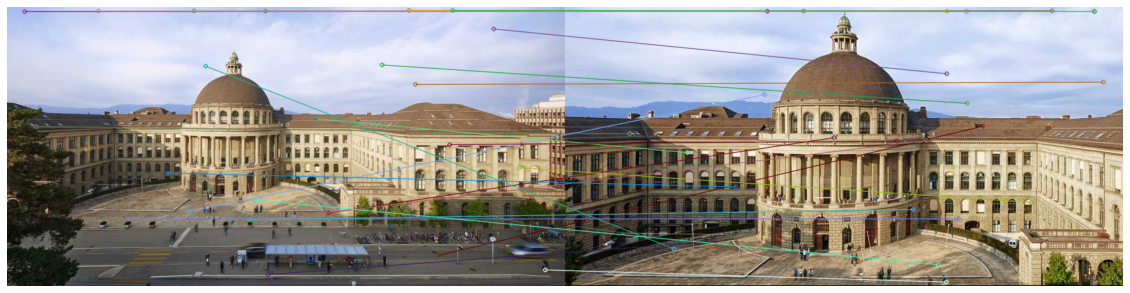

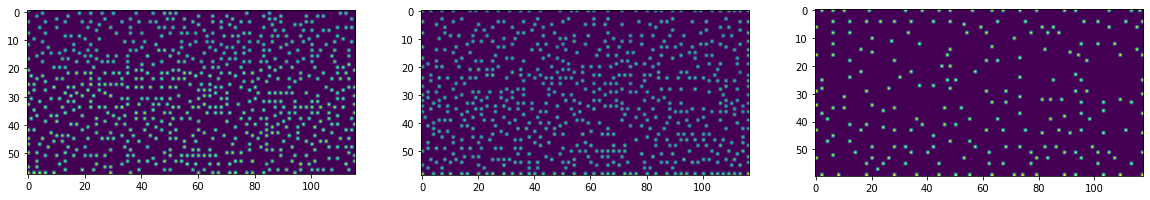

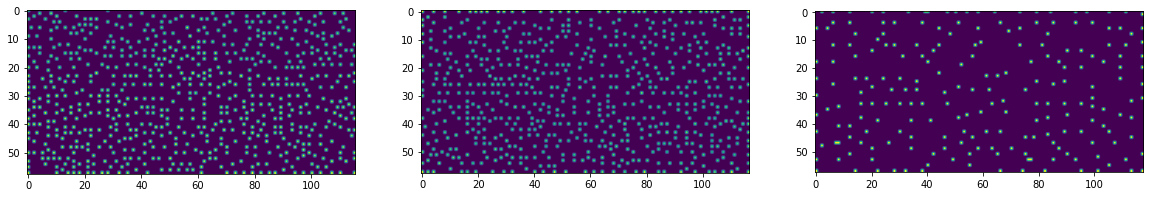

In [89]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

print(keypoints_left[inliers])
print(keypoints_right[inliers])


plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()

max_pool_torch = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
def nms(x):
    x = torch.tensor(x)
    lmax = torch.squeeze(max_pool_torch(torch.unsqueeze(x, dim=0)), dim=0)
    x[lmax != x] = 0
    return x.numpy()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det1[0])
axs[1].imshow(det1[1])
axs[2].imshow(det1[2])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det2[0])
axs[1].imshow(det2[1])
axs[2].imshow(det2[2])
plt.show()